In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random 

In [71]:
mu, sigma = 80.0, 4.5
# Group A: Telesecundaria, Educación a Distancia, IPEC, Bachillerato por Madurez
# Group B: Colegios técnicos públicos
# Group C: Resto de colegios públicos académicos
# Group D: Colegios privados y subvencionados
groups = {'A': 0.03, 'B': 0.12, 'C': 0.50, 'D': 0.35}
provinces = {'SJO': 0.3, 'ALA': 0.2, 'CAR': 0.3, 'HER': 0.06, 'GUA': 0.02, 'PUN': 0.04, 'LIM': 0.08}
groups_by_provinces = {'SJO': [0.05, 0.25, 0.55, 0.15],
                       'ALA': [0.05, 0.25, 0.60, 0.10],
                       'CAR': [0.05, 0.25, 0.60, 0.10],
                       'HER': [0.05, 0.25, 0.55, 0.15],
                       'GUA': [0.10, 0.20, 0.65, 0.05],
                       'PUN': [0.10, 0.20, 0.65, 0.05],
                       'LIM': [0.10, 0.20, 0.65, 0.05]}
dist_params_by_group = {'A': (80.0, 4.5), 'B': (80.0, 4.5), 'C': (80.0, 4.5), 'D': (80.0, 4.5)}
N = 21830

In [72]:
def gen_province(n):
    vals = []
    probs = []
    for k, v in provinces.items():
        vals.append(k)
        probs.append(v)
    return np.array(random.choices(vals, probs, k=n))

def choose_group(prov, prob_map):
    return random.choices(['A', 'B', 'C', 'D'], prob_map[prov], k=1)[0]

def gen_group(provs, prob_map):
    return np.array([choose_group(prov, prob_map) for prov in provs])

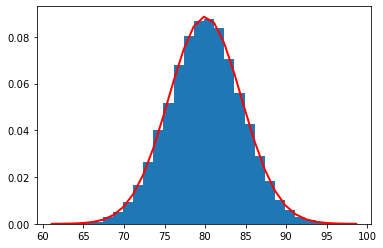

Min: 61.09021339892482. Max: 98.63657064686879


In [73]:
s = np.random.normal(mu, sigma, N)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()
print(f'Min: {np.min(s)}. Max: {np.max(s)}')

In [87]:
prov_data = gen_province(N)
group_data = gen_group(prov_data, groups_by_provinces)
df = pd.DataFrame(data={'province': prov_data, 'group': group_data})
df['grade'] = 0
s1 = df.loc[df.group == 'A', 'group']
df.head()


,province,group,grade
0,ALA,A,0
1,ALA,C,0
2,ALA,C,0
3,ALA,D,0
4,ALA,C,0
